# Projeto 15: Geração de imagens com GANs

- Código adaptado da documentação: https://www.tensorflow.org/beta/tutorials/generative/dcgan




# Etapa 1: Importação das bibliotecas

In [1]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf
tf.__version__

'2.8.2'

# Etapa 2: Importação e tratamento da base de dados

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_labels.shape

(60000,)

In [5]:
#tons de cinza
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
# Normalização entre -1 e 1
train_images = (train_images - 127.5) / 127.5

In [8]:
buffer_size = 60000
batch_size = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [10]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Etapa 3: Visualização dos dados

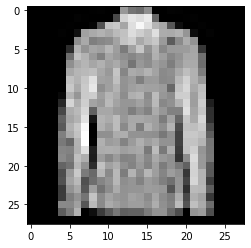

In [11]:
plt.imshow(train_images[112].reshape((28,28)) , cmap = 'gray')

# Etapa 4: Construção do gerador

In [12]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544 neuroniosblac
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  # 7x7x128
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 14x14x64
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 28x28x1
  #tanh pq normalizei entre -1,1
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  model.summary()

  return model

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.17609596, -0.41611797,  1.4714491 ,  0.5597708 , -0.0093091 ,
        -0.5283017 , -0.07626435, -0.39743823,  0.32969472,  1.7013131 ,
         0.26610658,  0.45203763,  0.26486042,  1.155645  , -1.3139528 ,
         0.19880708,  0.9373157 , -0.9571335 , -0.08655436, -0.8295233 ,
         0.8155578 ,  0.93778646,  1.1597674 , -1.017984  , -0.44000602,
        -1.717135  ,  0.39834362,  1.2074764 ,  0.14426555, -0.26557937,
        -1.3278947 , -2.3856304 , -0.6468707 ,  0.22293489, -0.59121794,
         0.12891813,  0.7588788 , -1.5083029 ,  1.1731292 , -1.5224411 ,
        -0.10254387,  0.40626895, -0.5551373 , -2.1853855 ,  0.19522206,
         0.9042481 , -1.3602777 ,  0.7577536 , -0.6184094 ,  0.26896328,
         0.07463096, -1.2937025 , -1.9659381 , -1.2718029 ,  0.1807687 ,
         0.17790481,  1.2041796 ,  0.8497234 , -0.7349934 ,  1.6582656 ,
         1.374285  ,  1.7530701 , -0.5664965 ,  0.48726016, -0.8836485 ,
 

In [15]:
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [16]:
generated_image = generator(noise, training = False)

In [17]:
generated_image.shape

TensorShape([1, 28, 28, 1])

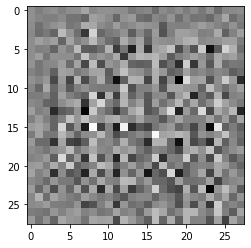

In [18]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

# Etapa 5: Construção do discriminador

In [19]:
def make_discrimator_model():
  model = tf.keras.Sequential()
  # 14x14x64
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 7x7x128
  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # 6272
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()

  return model

In [20]:
discriminator = make_discrimator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [21]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00187164]], dtype=float32)>

# Etapa 6: Loss function para as duas redes

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [24]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Etapa 7: Treinamento do modelo 

In [27]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

In [28]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [29]:
batch_size

256

In [35]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Chamar o gerador e passar os números aleatórios
    generated_images = generator(noise, training = True)

    # Passar para o discriminador as imagens reais e falsas para fazer a classificação
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    # Calcular a loss para o gerador e discriminador
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calcular o gradiente das losses para atualizar os pesos
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Aplicar os otimizadores e atualizar os pesos
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch + 1, seed) 

In [31]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

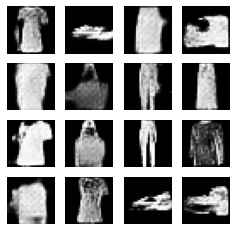

In [36]:
train(train_dataset, epochs)

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

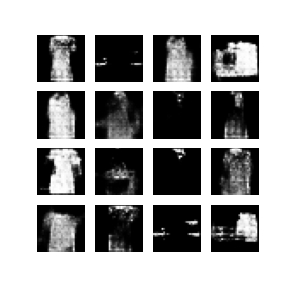

In [39]:
display_image(60)